<center><h1>Microstucture and Trading Systems</h1></center>

<center><h1>003 Deep Learning Project</h1></center>

<img src="Logo-ITESO.png" alt="Logo" width="500" style="display: block; margin: auto;">

<center><h3>Alejandra Flores Arias</h3></center>

<center><h3>Juan Pablo Guzmán Aceves</h3></center>


# Description

Create an algorithmic trading strategy optimizing the following hyperparameters with at least 50 trials:

- Stop Loss / Take Profit
- Number of shares per trade
- 3 Technical Indicators (Use the technical indicators to generate trading signals)
- Calculate the following metrics of the trading strategy (Sharpe, Sortino, Calmar ratios and Win/Loss percentage)
 

In [3]:
# Import librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import ta

In [4]:
data = pd.read_csv("aapl_5m_train.csv").dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


# Description of Indicators

### **RSI (Relative Strength Index)**  

The RSI is a momentum indicator that measures the speed and magnitude of price changes in an asset. It operates as an oscillator on a scale from 0 to 100, helping to identify overbought (>70) and oversold (<30) conditions. This makes it useful for spotting potential trend reversals and optimizing market entry or exit points.  

### **Bollinger Bands**  

Bollinger Bands consist of a central moving average and two outer bands set at a certain standard deviation, forming a volatility channel. When the bands expand, they indicate high volatility, whereas contractions suggest market consolidation. These bands are commonly used to assess the risk of sudden price movements and to detect trend breakouts.  

### **EMA (Exponential Moving Average)**  

The EMA is a moving average that assigns greater weight to recent data, making it more responsive to trend changes. It helps smooth out price fluctuations and determines the trend direction, often acting as dynamic support or resistance. The EMA plays a crucial role in algorithmic trading strategies and quantitative models.  


In [6]:
rsi = ta.momentum.RSIIndicator(data.Close, window=25)
bb = ta.volatility.BollingerBands(data.Close, window=16, window_dev=2) 
ema = ta.trend.EMAIndicator(data.Close, window=30)

# Creating "Buy" and "Sell" signals

In [8]:
dataset = data.copy()
dataset["RSI"] = rsi.rsi()
dataset["BB"] = bb.bollinger_mavg()
dataset["EMA"] = ema.ema_indicator()

dataset["RSI_BUY"] = dataset["RSI"] < 25
dataset["RSI_SELL"] = dataset["RSI"] > 75

dataset["BB_BUY"] = bb.bollinger_lband_indicator().astype(bool) # lower band
dataset["BB_SELL"] = bb.bollinger_hband_indicator().astype(bool) # higher band

dataset["EMA_BUY"] = dataset["Close"] > dataset["EMA"]  
dataset["EMA_SELL"] = dataset["Close"] < dataset["EMA"]

dataset = dataset.dropna()
dataset.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,RSI,BB,EMA,RSI_BUY,RSI_SELL,BB_BUY,BB_SELL,EMA_BUY,EMA_SELL
29,29,1609779300,0,2021-01-04 16:55:00,129.130004,129.179992,128.789993,128.820007,2439704.0,24.492226,130.022481,130.534815,True,False,False,False,False,True
30,30,1609779600,0,2021-01-04 17:00:00,128.809997,128.919296,128.399993,128.580001,2340696.0,23.230851,129.868418,130.408698,True,False,False,False,False,True
31,31,1609779900,0,2021-01-04 17:05:00,128.596694,128.770004,128.330001,128.351699,1508454.0,22.102922,129.718531,130.275989,True,False,False,False,False,True
32,32,1609780200,0,2021-01-04 17:10:00,128.233398,128.249893,127.400100,127.410003,4419879.0,18.287804,129.512294,130.091086,True,False,True,False,False,True
33,33,1609780500,0,2021-01-04 17:15:00,127.410003,128.029998,126.760002,128.005004,2891333.0,26.623658,129.325107,129.956500,False,False,False,False,False,True


# Strategy with long and short positions using the three indicators choseen

In [10]:
capital = 1000000
com = 0.125 / 100  # Comisión de compra/venta
n_shares = 1000  # Número de acciones por operación

portfolio_value = [capital]

stop_loss = 0.15  # Stop Loss del 15%
take_profit = 0.08  # Take Profit del 8%

win = 0
losses = 0

active_long_positions = None  # Solo una posición activa de cada tipo
active_short_positions = None

for i, row in dataset.iterrows():
    # === Cerrar posiciones largas (Long) ===
    if active_long_positions:
        # Cierre por Stop Loss
        if row.Close < active_long_positions["stop_loss"]:
            pnl = row.Close * n_shares * (1 - com)
            capital += pnl
            active_long_positions = None
            losses += 1

        # Cierre por Take Profit
        elif row.Close > active_long_positions["take_profit"]:
            pnl = row.Close * n_shares * (1 - com)
            capital += pnl
            active_long_positions = None
            win += 1

    # === Cerrar posiciones cortas (Short) ===
    if active_short_positions:
        # Cierre por Stop Loss
        if row.Close > active_short_positions["stop_loss"]:
            pnl = (active_short_positions["opened_at"] - row.Close) * n_shares * (1 - com)
            capital += pnl
            active_short_positions = None
            losses += 1

        # Cierre por Take Profit
        elif row.Close < active_short_positions["take_profit"]:
            pnl = (active_short_positions["opened_at"] - row.Close) * n_shares * (1 - com)
            capital += pnl
            active_short_positions = None
            win += 1

    # === Abrir posiciones largas (Long) ===
    if (row.RSI_BUY + row.BB_BUY + row.EMA_BUY) >= 2 and active_long_positions is None:
        cost = row.Close * n_shares * (1 + com)
        if capital >= cost:  # Solo abrir si hay capital suficiente
            capital -= cost
            active_long_positions = {
                "datetime": row.Datetime,
                "opened_at": row.Close,
                "take_profit": row.Close * (1 + take_profit),
                "stop_loss": row.Close * (1 - stop_loss),
            }

    # === Abrir posiciones cortas (Short) ===
    if (row.RSI_SELL + row.BB_SELL + row.EMA_SELL) >= 2 and active_short_positions is None:
        credit = row.Close * n_shares * (com)
        if capital >= credit:  # Solo abrir si hay capital suficiente
            capital -= credit  
            active_short_positions = {
                "datetime": row.Datetime,
                "opened_at": row.Close,
                "take_profit": row.Close * (1 - take_profit),
                "stop_loss": row.Close * (1 + stop_loss),
            }

    # === Calcular el valor del portafolio ===
    long_value = row.Close * n_shares if active_long_positions else 0
    short_value = (active_short_positions["opened_at"] - row.Close) * n_shares if active_short_positions else 0

    # Agregar el valor total del portafolio
    portfolio_value.append(capital + long_value + short_value)



# Portfolio Value vs Stock Price Plot

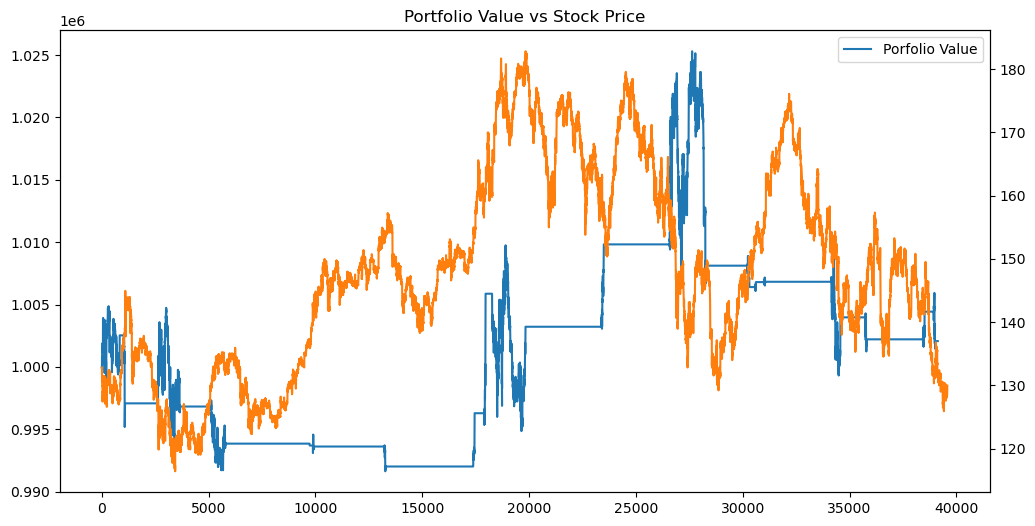

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(portfolio_value,label = "Porfolio Value")
ax.legend()
ax2 = ax.twinx()
ax2.plot(data.Close, c="C1")
plt.title("Portfolio Value vs Stock Price")

plt.show()

In [13]:
len(dataset)

39131

# Description of Ratios

### **Sharpe Ratio**  

The Sharpe Ratio measures the risk-adjusted return of an investment by comparing its excess return (over the risk-free rate) to its volatility. A higher Sharpe Ratio indicates better risk-adjusted performance, making it useful for evaluating investment strategies and portfolio optimization.  

$$Sharpe\ Ratio = \frac{\sqrt{N} \times (E(R_x) - R_f)}{\sigma_x}$$


Where:  
- $( N )$ = Number of periods (e.g., trading days in a year).  
- $( E(R_x) )$ = Expected return of the asset.  
- $( R_f )$ = Risk-free rate.  
- $( \sigma_x )$ = Standard deviation of returns (volatility).  


### **Sortino Ratio**  

The Sortino Ratio is a refinement of the Sharpe Ratio that focuses only on downside risk. It measures excess return relative to the standard deviation of negative returns, providing a clearer picture of risk-adjusted performance by ignoring upside volatility. This makes it ideal for assessing investments where minimizing losses is a priority.  

$$Sortino\ Ratio = \frac{E(R_x) - R_f}{\sigma_d}$$

Where:  
- $( E(R_x) )$ = Expected return of the asset.  
- $( R_f )$ = Risk-free rate.  
- $( \sigma_d )$ = Standard deviation of negative returns (downside risk).  


### **Calmar Ratio**  

The Calmar Ratio evaluates an investment’s risk-adjusted return by comparing its annualized return to the maximum drawdown. A higher Calmar Ratio suggests better performance with lower downside risk, making it valuable for assessing long-term portfolio stability, particularly in high-volatility markets.  

$$Calmar\ Ratio = \frac{R_{annualized}}{Max\ Drawdown}$$

Where:  
- $( R_{annualized} )$ = Annualized return of the investment.  
- $( Max\ Drawdown )$ = Largest peak-to-trough decline in portfolio value.  


### **Win/Loss Percentage**  

The Win/Loss Percentage calculates the proportion of profitable trades relative to total trades. It helps traders gauge the consistency of a strategy by measuring the frequency of winning trades. While useful, it should be analyzed alongside other risk metrics, as a high win percentage does not always indicate overall profitability.  

$$Win/Loss\ Percentage = \left( \frac{W}{W + L} \right) \times 100$$

Where:  
- $( W )$ = Number of winning trades.  
- $( L )$ = Number of losing trades.  


In [74]:
rf = 0
N = 252*78

# Sharpe

def sharpe_ratio(dataset, rf,N):
    
    returns = dataset["Close"].pct_change().dropna() 
    mean = returns.mean() # *N
    std = returns.std() # * np.sqrt(N)

    sharpe_ratio = np.sqrt(N)*(mean/std)

    return sharpe_ratio

sharpe = sharpe_ratio(dataset, rf,N)
print(f"Ratio de Sharpe: {sharpe:.4f}")

# Sortino

def sortino_ratio(dataset, N, rf=0):
    returns = dataset["Close"].pct_change().dropna()
    mean_excess_return = (returns.mean() - rf) * N  
    downside_std = returns[returns < 0].std() * np.sqrt(N)

    # Evitar división por cero
    if downside_std == 0:
        return np.nan  

    sortino_ratio = mean_excess_return / downside_std

    return sortino_ratio

sortino = sortino_ratio(dataset,N,rf)
print(f"Ratio de Sortino: {sortino:.4f}")


# Calmar

def calmar_ratio(dataset, N, rf):
    returns = dataset["Close"].pct_change().dropna()
    annualized_return = (returns.mean() - rf) * N

    
    cumulative_returns = (1 + returns).cumprod()  # Crecimiento del portafolio
    peak = cumulative_returns.cummax()  # Picos históricos
    dd = (cumulative_returns / peak) - 1  # Drawdown en cada punto
    max_dd = dd.min()  # Máximo drawdown registrado

    if max_dd == 0:
        return np.nan  

    calmar_ratio = annualized_return / abs(max_dd)

    return calmar_ratio

calmar = calmar_ratio(dataset, N, rf)
print(f"Ratio de Calmar: {calmar:.4f}")

# Win/Loss

def win_loss_percentage(dataset):
    returns = dataset["Close"].pct_change().dropna()
    wins = (returns > 0).sum()  # Retornos positivos
    total_trades = len(returns)  # Total de operaciones

    if total_trades == 0:
        return np.nan  

    win_loss_ratio = (wins / total_trades) * 100

    return win_loss_ratio

win_loss = win_loss_percentage(dataset)
print(f"Win/Loss Percentage: {win_loss:.2f}%")

Ratio de Sharpe: 0.1635
Ratio de Sortino: 0.2012
Ratio de Calmar: 0.1562
Win/Loss Percentage: 49.92%


In [16]:
def objective_func(trial, data):
    rsi_window = trial.suggest_int("rsi_window",10,100)
    rsi_lower = trial.suggest_int("rsi_lower",10,25)
    rsi_upper = trial.suggest_int("rsi_upper",70,95)

    stop_loss = trial.suggest_float("stop_loss",0.01,0.1)
    take_profit = trial.suggest_float("take_profit",0.05,0.2)
    n_shares = trial.suggest_categorical("n_shares",[1000,2000,4000,5000])
    
    bb_window= trial.suggest_int("bb_window",5,100)
    bb_window_dev= trial.suggest_int("bb_window_dev",1,3)
    ema_window= trial.suggest_int("ema_window",10,55)

    
    rsi = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    bb = ta.volatility.BollingerBands(data.Close, window=bb_window, window_dev=bb_window_dev) # dos desviaciones estandar
    ema = ta.trend.EMAIndicator(data.Close, window=ema_window)
    dataset = data.copy()
    dataset["RSI"] = rsi.rsi()
    dataset["BB"] = bb.bollinger_mavg()
    dataset["EMA"] = ema.ema_indicator()
    
    dataset["RSI_BUY"] = dataset["RSI"] < rsi_lower
    dataset["RSI_SELL"] = dataset["RSI"] > rsi_upper
    
    dataset["BB_BUY"] = bb.bollinger_lband_indicator().astype(bool) # lower band
    dataset["BB_SELL"] = bb.bollinger_hband_indicator().astype(bool) # higher band
    
    dataset["EMA_BUY"] = dataset["Close"] > dataset["EMA"]  
    dataset["EMA_SELL"] = dataset["Close"] < dataset["EMA"]

    dataset = dataset.dropna()
    capital = 1000000
    com = 0.125/100
    
    
    portfolio_value = [capital]
    
    
    
    win = 0
    losses = 0

    active_long_positions = None # una sola posicion activa de cada tipo
    active_short_positions = None
    
    for i, row in dataset.iterrows():
        # === Cerrar posiciones largas (Long) ===
        if active_long_positions:
            # Cierre por Stop Loss
            if row.Close < active_long_positions["stop_loss"]:
                pnl = row.Close * n_shares * (1 - com)
                capital += pnl
                active_long_positions = None
                losses += 1
    
            # Cierre por Take Profit
            elif row.Close > active_long_positions["take_profit"]:
                pnl = row.Close * n_shares * (1 - com)
                capital += pnl
                active_long_positions = None
                win += 1
    
        # === Cerrar posiciones cortas (Short) ===
        if active_short_positions:
            # Cierre por Stop Loss
            if row.Close > active_short_positions["stop_loss"]:
                pnl = (active_short_positions["opened_at"] - row.Close) * n_shares * (1 - com)
                capital += pnl
                active_short_positions = None
                losses += 1
    
            # Cierre por Take Profit
            elif row.Close < active_short_positions["take_profit"]:
                pnl = (active_short_positions["opened_at"] - row.Close) * n_shares * (1 - com)
                capital += pnl
                active_short_positions = None
                win += 1
    
        # === Abrir posiciones largas (Long) ===
        if (row.RSI_BUY + row.BB_BUY + row.EMA_BUY) >= 2 and active_long_positions is None:
            cost = row.Close * n_shares * (1 + com)
            if capital >= cost:  # Solo abrir si hay capital suficiente
                capital -= cost
                active_long_positions = {
                    "datetime": row.Datetime,
                    "opened_at": row.Close,
                    "take_profit": row.Close * (1 + take_profit),
                    "stop_loss": row.Close * (1 - stop_loss),
                }
    
        # === Abrir posiciones cortas (Short) ===
        if (row.RSI_SELL + row.BB_SELL + row.EMA_SELL) >= 2 and active_short_positions is None:
            credit = row.Close * n_shares * (com)
            if capital >= credit:  # Solo abrir si hay capital suficiente
                capital -= credit  
                active_short_positions = {
                    "datetime": row.Datetime,
                    "opened_at": row.Close,
                    "take_profit": row.Close * (1 - take_profit),
                    "stop_loss": row.Close * (1 + stop_loss),
                }
    
        # === Calcular el valor del portafolio ===
        long_value = row.Close * n_shares if active_long_positions else 0
        short_value = (active_short_positions["opened_at"] - row.Close) * n_shares if active_short_positions else 0
    
        # Agregar el valor total del portafolio
        portfolio_value.append(capital + long_value + short_value)
        returns = np.diff(portfolio_value) / portfolio_value[:-1]

    sharpe = sharpe_ratio(dataset,rf,N)
    sortino = sortino_ratio(dataset,N,rf)
    calmar = calmar_ratio(dataset, N, rf)
    win_loss = win_loss_percentage(dataset)

    return sharpe
   

In [17]:
study = optuna.create_study(direction="maximize") # que quiero, miniimizar o maximizar
study.optimize(lambda x: objective_func(x,data), n_trials=50)

[I 2025-03-26 19:23:10,065] A new study created in memory with name: no-name-f4069cbd-29ea-41a0-aa0a-0c7cd911f5a7
[I 2025-03-26 19:26:21,068] Trial 0 finished with value: 0.13408661991714135 and parameters: {'rsi_window': 89, 'rsi_lower': 10, 'rsi_upper': 91, 'stop_loss': 0.01285933667290458, 'take_profit': 0.07426872804682716, 'n_shares': 2000, 'bb_window': 78, 'bb_window_dev': 3, 'ema_window': 31}. Best is trial 0 with value: 0.13408661991714135.
[I 2025-03-26 19:50:30,060] Trial 1 finished with value: 0.16186660166822292 and parameters: {'rsi_window': 43, 'rsi_lower': 24, 'rsi_upper': 86, 'stop_loss': 0.012437546649147627, 'take_profit': 0.10880939362233637, 'n_shares': 1000, 'bb_window': 42, 'bb_window_dev': 3, 'ema_window': 52}. Best is trial 1 with value: 0.16186660166822292.
[I 2025-03-26 19:52:17,099] Trial 2 finished with value: 0.13603978406635617 and parameters: {'rsi_window': 58, 'rsi_lower': 12, 'rsi_upper': 94, 'stop_loss': 0.08462456283083102, 'take_profit': 0.0837972811

In [18]:
study.best_value

0.17813709337106728

In [19]:
study.best_params

{'rsi_window': 11,
 'rsi_lower': 15,
 'rsi_upper': 87,
 'stop_loss': 0.03655861705601031,
 'take_profit': 0.14384131817147283,
 'n_shares': 1000,
 'bb_window': 40,
 'bb_window_dev': 1,
 'ema_window': 38}